## Chapter 24 - Count Predicted Variable

- [24.2 - Example: Hair Eye Go Again](#24.2---Example:-Hair-Eye-Go-Again)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import mode, norm
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 24.2 - Example: Hair Eye Go Again

#### Data

In [3]:
df = pd.read_csv('data/HairEyeColor.csv', dtype={'Hair':'category', 'Eye':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
Hair     16 non-null category
Eye      16 non-null category
Count    16 non-null int64
dtypes: category(2), int64(1)
memory usage: 304.0 bytes


In [4]:
df.head()

,Hair,Eye,Count
0,Black,Blue,20
1,Black,Brown,68
2,Black,Green,5
3,Black,Hazel,15
4,Blond,Blue,94


In [6]:
pd.crosstab(df.Eye, df.Hair, values=df.Count, aggfunc=sum, margins=True)

Hair,Black,Blond,Brown,Red,All
Eye,,,,,
Blue,20.0,94.0,84.0,17.0,215.0
Brown,68.0,7.0,119.0,26.0,220.0
Green,5.0,16.0,29.0,14.0,64.0
Hazel,15.0,10.0,54.0,14.0,93.0
All,108.0,127.0,286.0,71.0,592.0


#### Model (Kruschke, 2015)

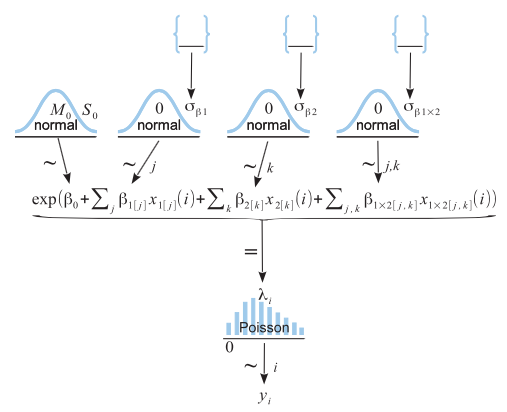

In [7]:
Image('images/fig24_2.png')

In [8]:
y = df.Count
x1 = df.Eye.cat.codes
x2 = df.Hair.cat.codes
x1levels = df.Eye.cat.categories
x2levels = df.Hair.cat.categories
Nx1Lvl = len(x1levels)
Nx2Lvl = len(x2levels)
Ncell = len(df.Count)

yLogMean = np.log(np.sum(y)/(Nx1Lvl*Nx2Lvl))
yLogSD = np.log(np.std(np.r_[np.repeat([0], Ncell-1), np.sum(y)], ddof=1))
agammaShRa = gammaShRaFromModeSD(yLogSD, 2*yLogSD)

with pm.Model() as poisson_model:
        a0 = pm.Normal('a0', yLogMean, tau=1/(yLogSD*2)**2)

        a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
        a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
        
        a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
        a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
        
        a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
        a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
        lmbda = pm.exp(a0 + a1[x1] + a2[x2] +a1a2[x1, x2])
        
        y = pm.Poisson('y', lmbda, observed=y)

Applied log-transform to a1SD and added transformed a1SD_log_ to model.
Applied log-transform to a2SD and added transformed a2SD_log_ to model.
Applied log-transform to a1a2SD and added transformed a1a2SD_log_ to model.


In [9]:
n_samples = 2500
with poisson_model:
    trace1 = pm.sample(n_samples)

Assigned NUTS to a0
Assigned NUTS to a1SD_log_
Assigned NUTS to a1
Assigned NUTS to a2SD_log_
Assigned NUTS to a2
Assigned NUTS to a1a2SD_log_
Assigned NUTS to a1a2
 [-----------------100%-----------------] 2500 of 2500 complete in 165.6 sec

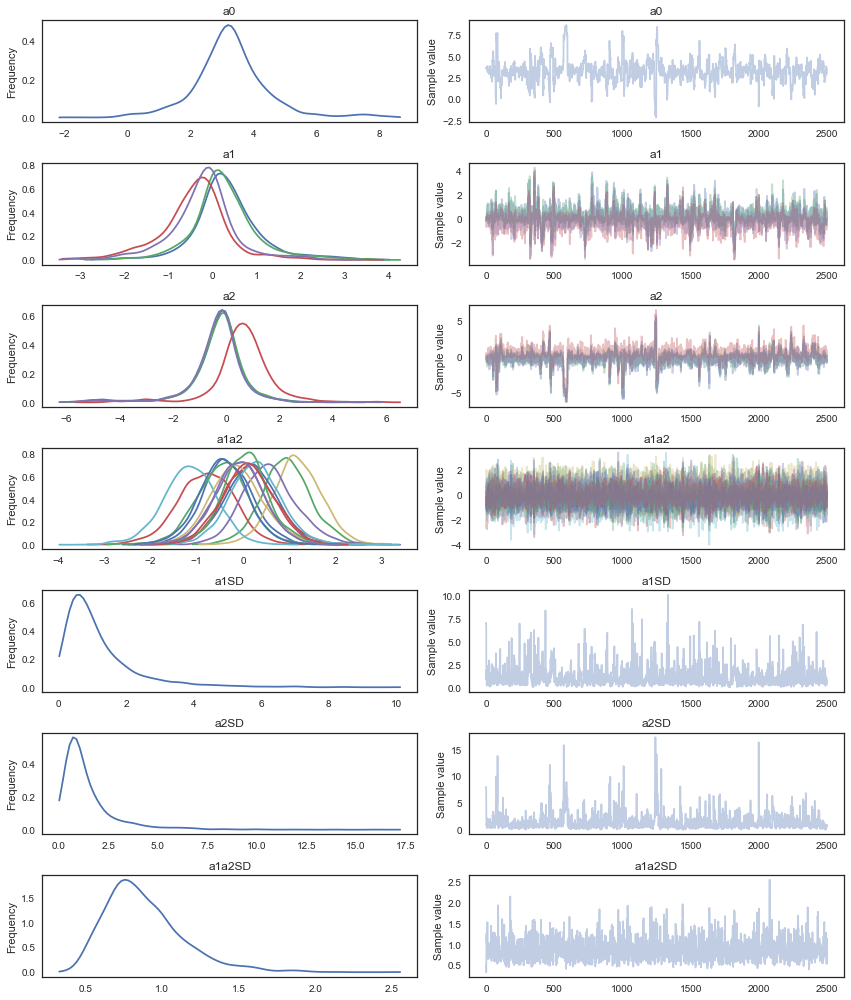

In [10]:
pm.traceplot(trace1);

In [11]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Compute predicted proportions
expm = np.exp(m)
ppx1x2p = expm/np.sum(expm, axis=(0,1))

ppx1p = np.sum(ppx1x2p, axis=(0,1))
ppx2p = np.sum(ppx1x2p, axis=(1,0))

#### Figure 24.3

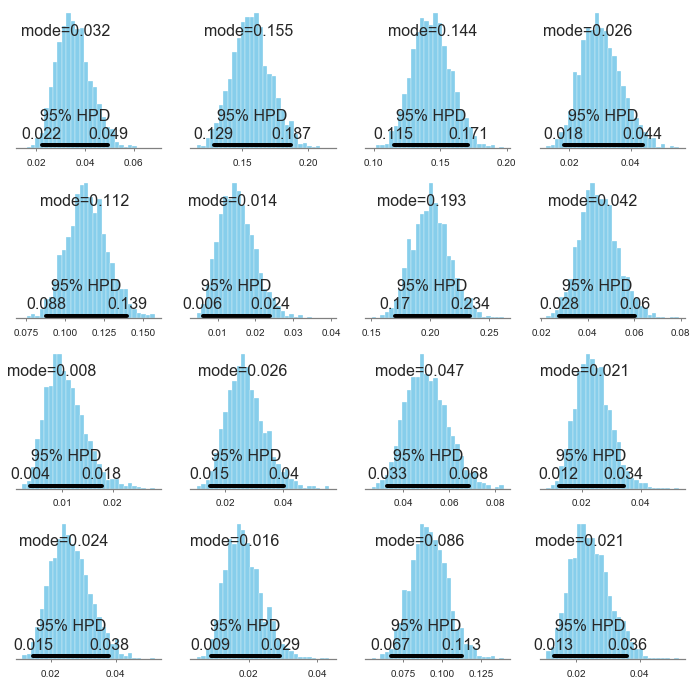

In [14]:
burnin = 250

# Define gridspec
fig, axes = plt.subplots(4,4, figsize=(12,12))
for (r, c), ax in np.ndenumerate(axes):
    pm.plot_posterior(ppx1x2p[r,c,:][burnin:], point_estimate='mode', color=color, ax=ax);